---
# Homework 2:

In [1]:
# import numpy for calculating stuff
import numpy as np
import pandas as pd
import os 

# For storing objects
import pickle

# You can use a another tool from deepdish to do the same thing:
# http://deepdish.io/ , comment out next line for using deepdish
import deepdish as dd

# Astronomical packages
import astropy

# importing skit-learn library
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# import matplotlib.pyplot for plotting stuff
import matplotlib.pyplot as plt

# font parameters dictionary
font = {'family' : 'serif',
        'weight' : 'bold',
}
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)

# Set the font parameters
plt.rc('font', **font) 


# Formating a number into scientific notation
def format_e(n):
    a = '{:.2E}'.format(n)
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

## Problem 1: Bayesian Inference:

### 0.4 point

In [2]:
data = np.array([16, 24, 16, 12, 16, 11, 14, 15, 9, 14, 7])

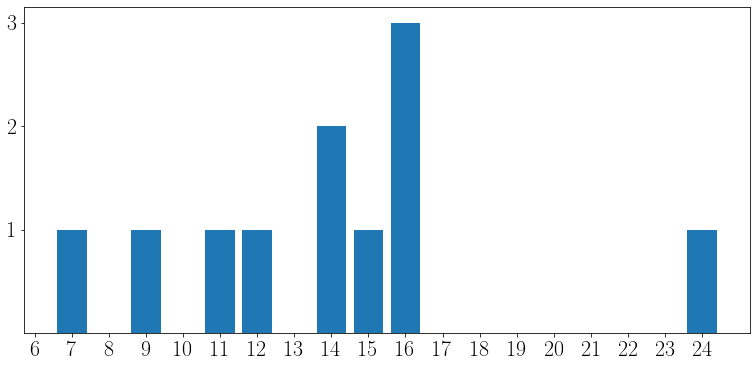

In [7]:
plt.figure(figsize=(13, 6))

labels, counts = np.unique(data, return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(range(6, 25))
plt.yticks(range(1, 4))
plt.tick_params(labelsize=22);

## Poisson distribution?

$$p(k \mid \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

In [3]:
from math import factorial

In [4]:
@np.vectorize
def poisson(k, λ=2):
    return λ**k * np.exp(-λ) / factorial(k)

In [5]:
ks = np.arange(0, 25)
ps = poisson(ks, 2.2)

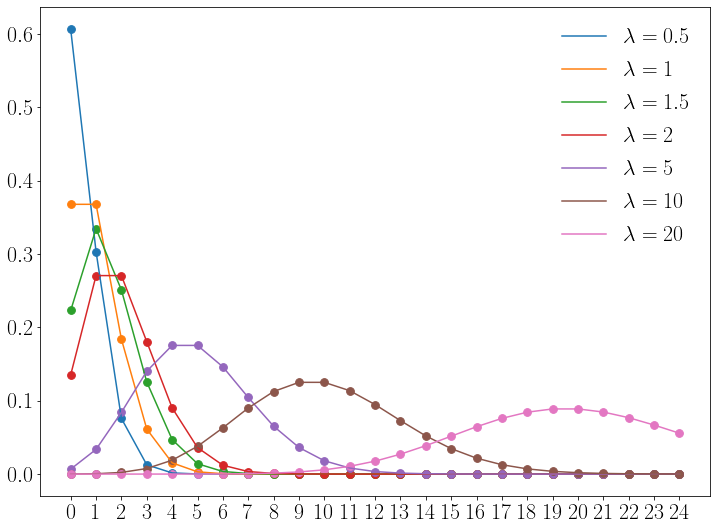

In [6]:
plt.figure(figsize=(12, 9))


for λ in [0.5, 1, 1.5, 2, 5, 10, 20]:
    ps = poisson(ks, λ)
    plt.plot(ks, ps, label=r"$\lambda = {}$".format(λ))
    plt.scatter(ks, ps, s=60)
plt.xticks(ks)
plt.legend(frameon=False, fontsize=22)
plt.tick_params(labelsize=22);

### Model:
$$
p(\lambda) = \frac{1}{\lambda_{max} - \lambda_{min}} \\
p(k \mid \lambda) = \frac{\lambda^k e^{-\lambda}}{k!} \\
$$
Using Bayes:
$$
p(\lambda | \text{data}) \propto p(\text{data} \mid \lambda) p(\lambda)  \\
p(\text{data} \mid \lambda) = \prod_{k}p(k \mid \lambda)\\
\ln(p(\lambda | \text{data})) \propto \ln(p(\lambda)) + \sum_k \ln(p(k \mid \lambda))
$$

In [7]:
@np.vectorize
def ln_prior(λ, MIN, MAX):
    p = 1/(MAX - MIN)
    if MIN <= λ <= MAX:
        return np.log(p)
    else:
        return -np.inf

In [8]:
def ln_likelihood(ks, λ):
    return np.sum(np.log(poisson(ks, λ)))

In [9]:
MIN, MAX = 0.001, 100
λ_span = np.linspace(MIN, MAX, 3000)

In [23]:
Π_min, Π_max = 5, 20

ln_posterior = []
ln_likelihoods = []

for λ in λ_span:
    ln_posterior += [ln_prior(λ, Π_min, Π_max) + ln_likelihood(data, λ)]
    ln_likelihoods += [ln_likelihood(data, λ)]
    
ln_posterior = np.array(ln_posterior)
ln_likelihoods = np.array(ln_likelihoods)

In [24]:
from scipy.integrate import trapz

In [25]:
posterior_probability = np.exp(ln_posterior) / trapz(np.exp(ln_posterior), λ_span)

likelihoods = (np.exp(ln_likelihoods)/np.exp(ln_likelihoods).max()) * max(posterior_probability) 

prior = np.exp(ln_prior(λ_span, Π_min, Π_max))

In [26]:
MAP_estimate = float(λ_span[posterior_probability == posterior_probability.max()])

In [27]:
MAP_estimate, data.mean()

(14.005528176058684, 14.0)

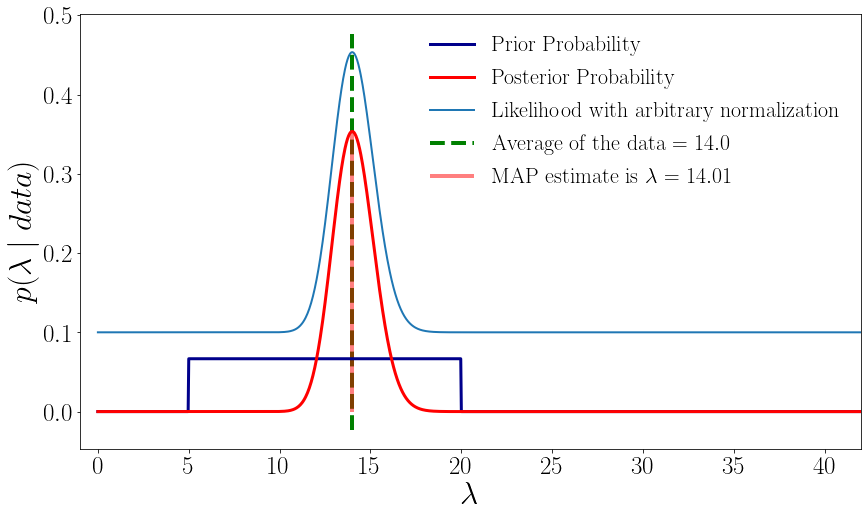

In [28]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(λ_span, prior, label="Prior Probability", color="darkblue", lw=3)
ax.plot(λ_span, posterior_probability, label="Posterior Probability", color="r", lw=3)

ax.plot(λ_span, likelihoods + 0.1, label="Likelihood with arbitrary normalization", lw=2)


ax.vlines(data.mean(), *plt.gca().get_ylim(), label=r"Average of the data $={}$".format(round(data.mean(), 2)), color="g", ls="--", lw=4)

ax.vlines(MAP_estimate, 0, posterior_probability.max(), label=r"MAP estimate is $\lambda = {}$".format(round(MAP_estimate, 2)), color="r", lw=4, alpha=0.5)

ax.tick_params(labelsize=25)

ax.set_xlabel(r"$\lambda$", fontsize=32)
ax.set_ylabel(r"$p(\lambda \mid data)$", fontsize=32)

ax.set_xlim(-1, 42)

ax.legend(fontsize=22, frameon=False, loc="upper right");

## Posterior Predictive Probability:

$$
p(x_n \mid \{x_i\}_{i=1}^{n-1}) = \int d\lambda p(x_n, \lambda \mid \{x_i\}_{i=1}^{n-1}) = \int d\lambda p(x_n \mid \lambda, \{x_i\}_{i=1}^{n-1}) p(\lambda \mid \{x_i\}_{i=1}^{n-1}) = \int d\lambda p(x_n \mid \lambda) p(\lambda \mid \{x_i\}_{i=1}^{n-1}) \\
\to \boxed{p(x_n \mid \{x_i\}_{i=1}^{n-1}) = \int d\lambda p(x_n \mid \lambda) p(\lambda \mid \{x_i\}_{i=1}^{n-1})}
$$

In [29]:
x_span = np.arange(1, 100, dtype=int)
posterior_predictive = []
for x in x_span:
    p = poisson(x, λ_span)
    posterior_predictive += [trapz(p * posterior_probability, λ_span)]
    
posterior_predictive = np.array(posterior_predictive)

In [30]:
float(x_span[posterior_predictive == posterior_predictive.max()])

13.0

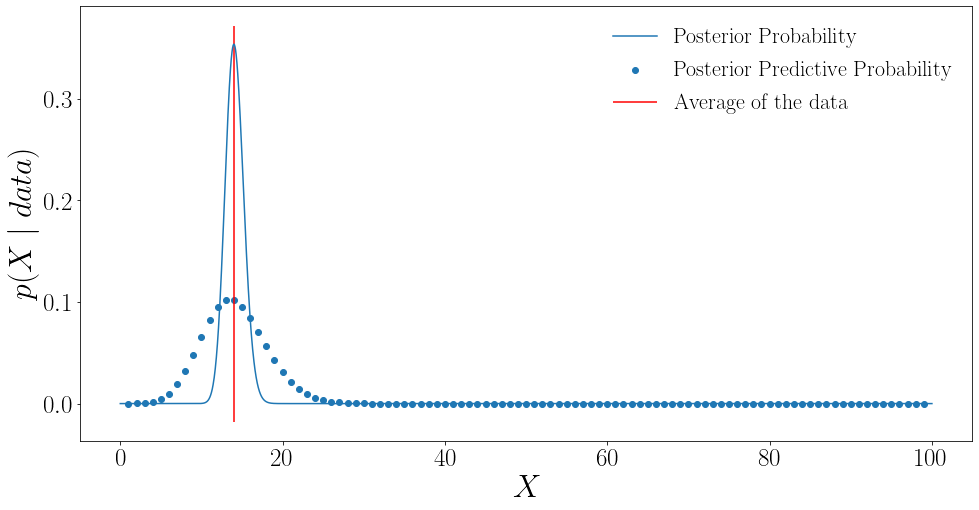

In [31]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_span, posterior_predictive, label="Posterior Predictive Probability")
# ax.hist(data, density=True, alpha=0.1)

ax.plot(λ_span, posterior_probability, label="Posterior Probability")
ax.vlines(data.mean(), *plt.gca().get_ylim(), label="Average of the data", color="r")
ax.tick_params(labelsize=25)

ax.set_xlabel(r"$X$", fontsize=32)
ax.set_ylabel(r"$p(X \mid data)$", fontsize=32)

ax.legend(fontsize=22, frameon=False, loc="upper right");

In [32]:
posterior_predictive.sum()

0.9999986107711829

In [33]:
sample = np.random.choice(x_span, p=posterior_predictive/posterior_predictive.sum(), size=50000)

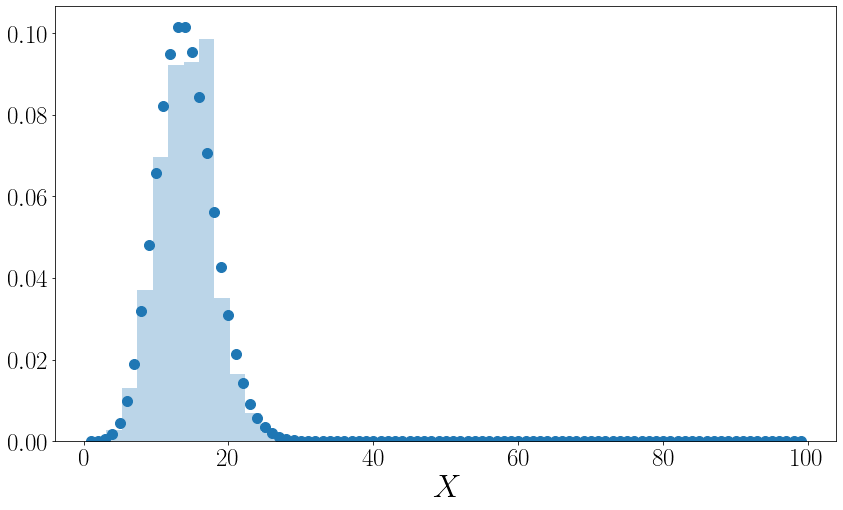

In [34]:
plt.figure(figsize=(14, 8))
plt.hist(sample, density=True, alpha=0.3, bins=15)
plt.scatter(x_span, posterior_predictive, label="Predictive Posterior Probability", s=100)

plt.tick_params(labelsize=25)

plt.xlabel(r"$X$", fontsize=32)

plt.show()

In [35]:
sample[:40]

array([10, 14, 12, 15, 22,  8, 16, 19, 18, 11, 12, 12, 20, 14, 23, 18,  7,
        8, 14, 15, 15, 12, 14, 16, 15, 10, 15, 14, 15, 12, 12, 10,  8, 26,
       14, 13, 13, 23, 14, 23])

### Without integral and using a generative process
$$
\lambda \sim p(\lambda \mid {data}) \\
x \sim p(x \mid \lambda)
$$

In [36]:
sample_1 = []
for i in range(10000):
    λ = np.random.choice(λ_span, p=posterior_probability/posterior_probability.sum())
    sample_1 += [np.random.poisson(lam=λ)]

In [37]:
sample_1[:20]

[15, 12, 9, 16, 7, 11, 17, 8, 10, 11, 15, 8, 16, 19, 15, 11, 15, 11, 13, 10]

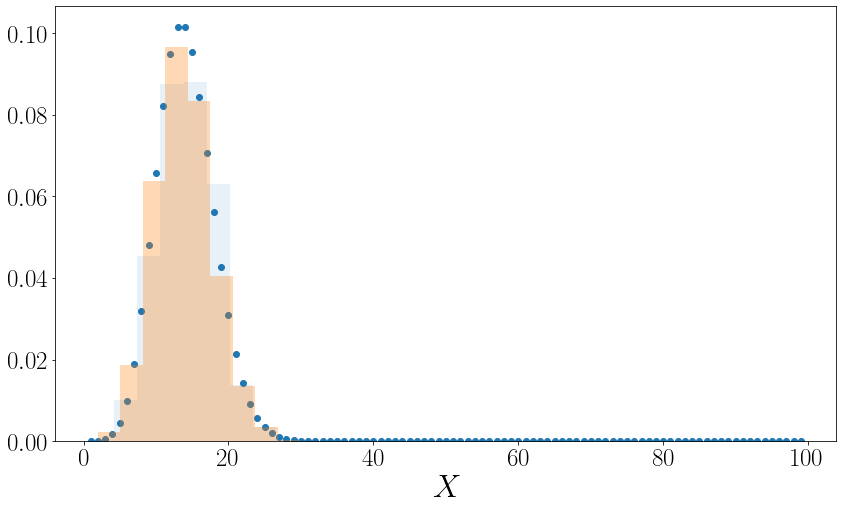

In [38]:
plt.figure(figsize=(14, 8))

plt.hist(sample, density=True, alpha=0.1)
plt.hist(sample_1, density=True, alpha=0.3)
plt.scatter(x_span, posterior_predictive, label="Predictive Posterior Probability", )
plt.tick_params(labelsize=25)

plt.xlabel(r"$X$", fontsize=32)


plt.show()

# Problem 2:
### 0.4 point

In [39]:
import lhsmdu as sampler

In [40]:
def g(w):
    return w.T @ w

In [ ]:
w.shape

In [94]:
N = 2
P = 10

sample = np.array(sampler.sample(N, P)) * 2 - 1
sample.shape

(2, 10)

In [100]:
P = 100
min_values = []
for N in range(1, 101):
    sample = np.array(sampler.sample(N, P)) * 2 - 1
    
    g_values = []
    for w in sample.T:
        g_values += [g(w)]
    
    if N % 10 == 0:
        print("Dimension N={} is done!".format(N))
        
    min_values += [min(g_values)]
min_values = np.array(min_values)

Dimension N=10 is done!
Dimension N=20 is done!
Dimension N=30 is done!
Dimension N=40 is done!
Dimension N=50 is done!
Dimension N=60 is done!
Dimension N=70 is done!
Dimension N=80 is done!
Dimension N=90 is done!
Dimension N=100 is done!


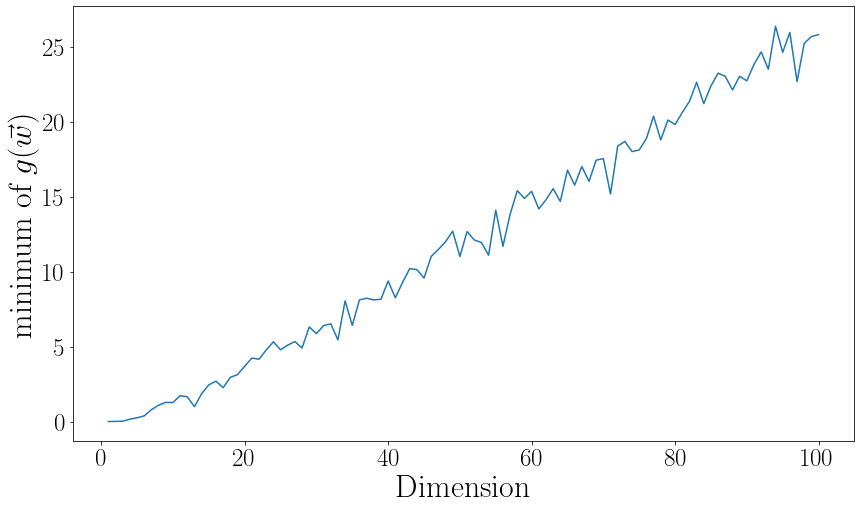

In [101]:
plt.figure(figsize=(14, 8))

plt.plot(range(1, 101), min_values)
plt.tick_params(labelsize=25)

plt.xlabel(r"Dimension", fontsize=32)
plt.ylabel(r"minimum of $g(\vec{w})$", fontsize=32)


plt.show()

In [124]:
min_values_sample_size = [list(min_values)]

### DON'T RUN AGAIN :D

In [126]:
for P in [200, 400]:
    min_values = []
    print("====" * 10)

    for N in range(1, 101):
        sample = np.array(sampler.sample(N, P)) * 2 - 1

        g_values = []
        for w in sample.T:
            g_values += [g(w)]

        if N % 10 == 0:
            print("Dimension N={} is done!".format(N))

        min_values += [min(g_values)]
    min_values_sample_size += [min_values]
    

Dimension N=10 is done!
Dimension N=20 is done!
Dimension N=30 is done!
Dimension N=40 is done!
Dimension N=50 is done!
Dimension N=60 is done!
Dimension N=70 is done!
Dimension N=80 is done!
Dimension N=90 is done!
Dimension N=100 is done!
Dimension N=10 is done!
Dimension N=20 is done!
Dimension N=30 is done!
Dimension N=40 is done!
Dimension N=50 is done!
Dimension N=60 is done!
Dimension N=70 is done!
Dimension N=80 is done!
Dimension N=90 is done!
Dimension N=100 is done!


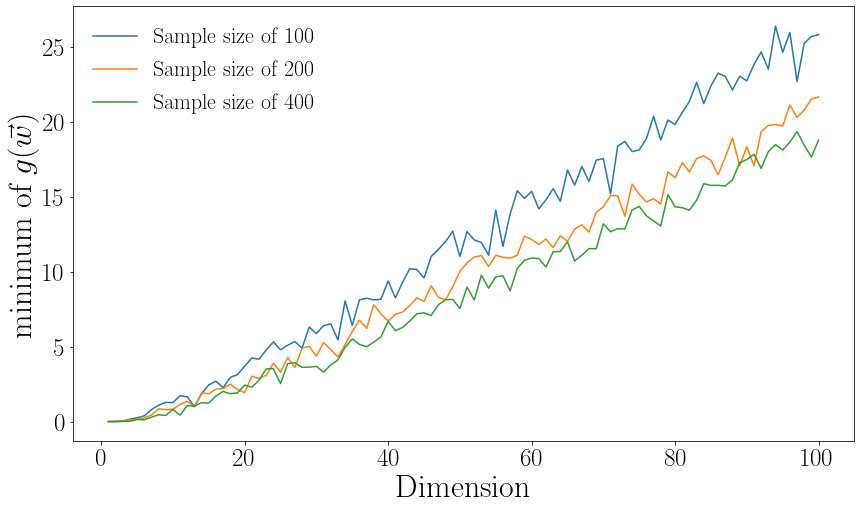

In [144]:
plt.figure(figsize=(14, 8))

for i, P in enumerate([100, 200, 400]):
    plt.plot(range(1, 101), np.array(min_values_sample_size[i]), label=f"Sample size of {P}")
plt.tick_params(labelsize=25)

plt.xlabel(r"Dimension", fontsize=32)
plt.ylabel(r"minimum of $g(\vec{w})$", fontsize=32)


plt.legend(fontsize=22, frameon=False, loc="upper left");
plt.show()

## Curse of Dimensionality

In [41]:
from scipy.special import  gamma

In [42]:
n = 2

fraction_of_volume = []


for n in range(2, 20):
    volume_of_hypercube = 2**n
    volume_of_hypersphere = np.pi**(n/2) / gamma(n/2 + 1)
    fraction_of_volume += [volume_of_hypersphere / volume_of_hypercube]


In [43]:
(np.pi) / 2**2 

0.7853981633974483

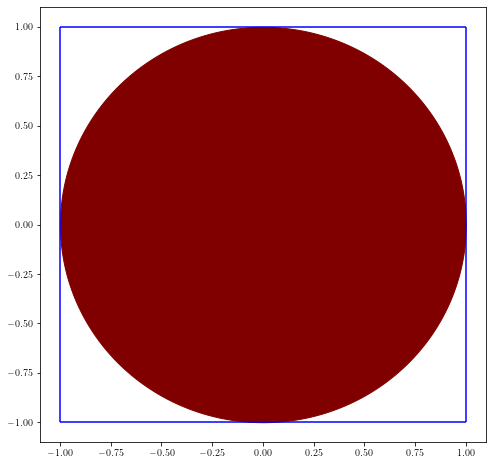

In [148]:
plt.figure(figsize=(8, 8))

plt.hlines(-1, -1, 1, color="b")
plt.hlines(1, -1, 1, color="b")
plt.vlines(-1, -1, 1, color="b")
plt.vlines(1, -1, 1, color="b")

x = np.linspace(-1, 1, 1000)
plt.fill_between(x, 0, np.sqrt(1 - x**2), color="maroon", alpha=1)
plt.fill_between(x, 0, -np.sqrt(1 - x**2), color="maroon", alpha=1)

plt.show()

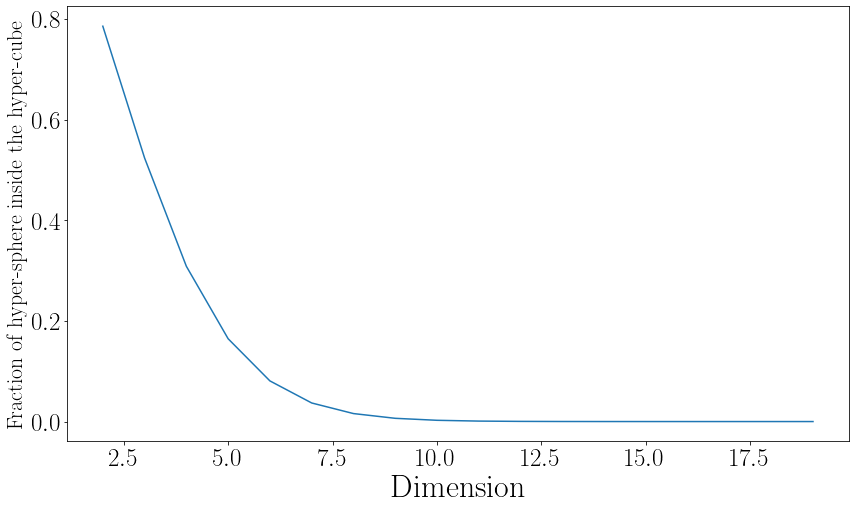

In [149]:
plt.figure(figsize=(14, 8))

plt.plot(range(2, 20), fraction_of_volume)
plt.tick_params(labelsize=25)

plt.xlabel(r"Dimension", fontsize=32)
plt.ylabel(r"Fraction of hyper-sphere inside the hyper-cube", fontsize=22)


plt.show()

---
# Problem 3:
### 0.2 point
$$
g(\vec{w}) = a + \vec{b}^T \vec{w} + \vec{w}^T C \vec{w} \quad \text{And} \quad C = \frac{1}{\beta} I \\
\nabla_w g(w) = \vec{b} + 2 C \vec{w} \\
\nabla_w g(w) = 0 \to 2 C \vec{w} = - \vec{b} \\
\frac{2}{\beta} I \vec{w} = - \vec{b}\\
\boxed{\vec{w} = - \frac{1}{2} \beta \vec{b}}
$$

--- 
